In [34]:
import pandas as pd
import numpy as np
import os

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns


from tensorflow.keras.layers import InputLayer
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam

In [19]:
# load data
df = pd.read_csv("cover_data.csv")
df.head()

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,...,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40,class
0,2596,51,3,258,0,510,221,232,148,6279,...,0,0,0,0,0,0,0,0,0,5
1,2590,56,2,212,-6,390,220,235,151,6225,...,0,0,0,0,0,0,0,0,0,5
2,2804,139,9,268,65,3180,234,238,135,6121,...,0,0,0,0,0,0,0,0,0,2
3,2785,155,18,242,118,3090,238,238,122,6211,...,0,0,0,0,0,0,0,0,0,2
4,2595,45,2,153,-1,391,220,234,150,6172,...,0,0,0,0,0,0,0,0,0,5


In [20]:
# select features and labels
features = df.iloc[:, : -1]
labels = df.iloc[:, -1]

In [21]:
# train test set split
features_train, features_test, labels_train, labels_test = train_test_split(
    features, 
    labels, 
    test_size = 0.2,
    random_state = 0,
    stratify = labels
)

In [22]:
# scale features
sc = StandardScaler()
features_train_scaled = sc.fit_transform(features_train)
features_test_scaled = sc.transform(features_test)

In [28]:
# build model
def build_model(learning_rate):
    model = Sequential()
    
    # input layer
    model.add(InputLayer(input_shape = (features_train_scaled.shape[1],)))
    
    #add hidden layers
    model.add(Dense(8, activation = "relu"))
    model.add(Dense(128, activation = "relu"))
    model.add(Dense(256, activation = "relu"))
    model.add(Dense(64, activation = "relu"))
    model.add(Dense(32, activation = "relu"))
    model.add(Dense(16, activation = "relu"))
    
    # output layer
    model.add(Dense(8, activation = "softmax"))
    
    #optimize model with adam
    opt = Adam(learning_rate = learning_rate)
    
    #compile model
    model.compile(
        loss = "sparse_categorical_crossentropy",  
        metrics = ["accuracy"], 
        optimizer = opt
    )
    model.summary()
    return model

In [29]:
# fit model
def fit_model(learning_rate, num_epochs, batch_size):
    model = build_model(learning_rate)
    stop = EarlyStopping(
        monitor = "val_accuracy", 
        mode = "auto",
        verbose = 1, 
        patience = 10 
    )
    history = model.fit(
        features_train,
        labels_train,
        epochs = num_epochs,
        batch_size = batch_size,
        verbose = 1,
        #use 10% of data for validation
        validation_split = 0.1, 
        callbacks = [stop]
    )
    return history, features_test, labels_test

In [25]:
#visualize model performance
def accuracy_viz(history):
    #plot accuracy
    fig = plt.figure(figsize = (15,10))
    ax1 = fig.add_subplot(2, 1, 1)
    ax1.plot(history.history['accuracy'])
    ax1.plot(history.history['val_accuracy'])
    ax1.set_title('Accuracy of model')
    ax1.set_ylabel('Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.legend(['train', 'validation'], loc='upper left')
    
    # Plot loss and val_loss over each epoch
    ax2 = fig.add_subplot(2, 1, 2)
    ax2.plot(history.history['loss'])
    ax2.plot(history.history['val_loss'])
    ax2.set_title('Learning Curve')
    ax2.set_ylabel('Loss')
    ax2.set_xlabel('Epoch')
    ax2.legend(['train', 'validation'], loc='upper left') 
    fig.tight_layout()
    

def heatmap_viz(class_names, y_pred, y_test):
    cm = confusion_matrix(y_test, y_pred)
    fig, ax = plt.subplots(figsize=(15, 15))
    heatmap = sns.heatmap(cm, fmt='g', cmap='Blues', annot=True, ax=ax)
    ax.set_xlabel('Predicted class')
    ax.set_ylabel('True class')
    ax.set_title('Confusion Matrix')
    ax.xaxis.set_ticklabels(class_names)
    ax.yaxis.set_ticklabels(class_names)
    # Save heatmap
    heatmapfig = heatmap.get_figure()
    heatmapfig.savefig('confusion_matrix.png')
    

In [26]:
#model report
from sklearn.metrics import classification_report
import numpy as np

class_names = ['Spruce/Fir', 'Lodgepole Pine',
                   'Ponderosa Pine', 'Cottonwood/Willow',
                   'Aspen', 'Douglas-fir', 'Krummholz']

def gen_report(model, features_test, labels_test):
    score = model.evaluate(features_test, labels_test, verbose = 0)
    print(f'Test loss: {score[0]}')
    print(f'Test accuracy: {score[1]}')

    # evaluating the model:
    y_pred = model.predict(features_test)
    
    # Convert the pred to discrete values
    y_pred = np.argmax(y_pred, axis=1)
    
    print(classification_report(labels_test, y_pred, target_names = class_names))

    return y_pred

In [35]:
learning_rate = 0.00003
num_epochs = 200
batch_size = 1024

history, features_test, labels_test = fit_model(learning_rate, num_epochs, batch_size)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 440       
_________________________________________________________________
dense_1 (Dense)              (None, 128)               1152      
_________________________________________________________________
dense_2 (Dense)              (None, 256)               33024     
_________________________________________________________________
dense_3 (Dense)              (None, 64)                16448     
_________________________________________________________________
dense_4 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_5 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_6 (Dense)              (None, 8)                

409/409 [==============================] - 2s 5ms/step - loss: 0.8052 - accuracy: 0.6459 - val_loss: 0.8117 - val_accuracy: 0.6280
Epoch 50/200
409/409 [==============================] - 2s 4ms/step - loss: 0.8025 - accuracy: 0.6471 - val_loss: 0.8053 - val_accuracy: 0.6413
Epoch 51/200
409/409 [==============================] - 2s 4ms/step - loss: 0.8022 - accuracy: 0.6464 - val_loss: 0.7943 - val_accuracy: 0.6543
Epoch 52/200
409/409 [==============================] - 2s 4ms/step - loss: 0.7977 - accuracy: 0.6487 - val_loss: 0.7977 - val_accuracy: 0.6529
Epoch 53/200
409/409 [==============================] - 2s 5ms/step - loss: 0.7950 - accuracy: 0.6507 - val_loss: 0.7941 - val_accuracy: 0.6440
Epoch 54/200
409/409 [==============================] - 2s 5ms/step - loss: 0.7939 - accuracy: 0.6508 - val_loss: 0.7921 - val_accuracy: 0.6502
Epoch 55/200
409/409 [==============================] - 2s 4ms/step - loss: 0.7918 - accuracy: 0.6518 - val_loss: 0.7882 - val_accuracy: 0.6514
Epoch

Epoch 106/200
409/409 [==============================] - 2s 4ms/step - loss: 0.7187 - accuracy: 0.6866 - val_loss: 0.7229 - val_accuracy: 0.6839
Epoch 107/200
409/409 [==============================] - 2s 4ms/step - loss: 0.7168 - accuracy: 0.6880 - val_loss: 0.7181 - val_accuracy: 0.6875
Epoch 108/200
409/409 [==============================] - 2s 4ms/step - loss: 0.7169 - accuracy: 0.6872 - val_loss: 0.7147 - val_accuracy: 0.6814
Epoch 109/200
409/409 [==============================] - 2s 4ms/step - loss: 0.7142 - accuracy: 0.6890 - val_loss: 0.7078 - val_accuracy: 0.6950
Epoch 110/200
409/409 [==============================] - 2s 4ms/step - loss: 0.7140 - accuracy: 0.6890 - val_loss: 0.7101 - val_accuracy: 0.6925
Epoch 111/200
409/409 [==============================] - 2s 4ms/step - loss: 0.7120 - accuracy: 0.6899 - val_loss: 0.7127 - val_accuracy: 0.6891
Epoch 112/200
409/409 [==============================] - 2s 4ms/step - loss: 0.7113 - accuracy: 0.6914 - val_loss: 0.7089 - val_ac

409/409 [==============================] - 2s 4ms/step - loss: 0.6681 - accuracy: 0.7123 - val_loss: 0.6666 - val_accuracy: 0.7104
Epoch 163/200
409/409 [==============================] - 2s 4ms/step - loss: 0.6685 - accuracy: 0.7115 - val_loss: 0.6632 - val_accuracy: 0.7129
Epoch 164/200
409/409 [==============================] - 2s 4ms/step - loss: 0.6683 - accuracy: 0.7108 - val_loss: 0.6761 - val_accuracy: 0.7083
Epoch 165/200
409/409 [==============================] - 2s 4ms/step - loss: 0.6663 - accuracy: 0.7126 - val_loss: 0.6634 - val_accuracy: 0.7128
Epoch 166/200
409/409 [==============================] - 2s 4ms/step - loss: 0.6665 - accuracy: 0.7124 - val_loss: 0.6598 - val_accuracy: 0.7148
Epoch 167/200
409/409 [==============================] - 2s 4ms/step - loss: 0.6634 - accuracy: 0.7142 - val_loss: 0.6646 - val_accuracy: 0.7115
Epoch 168/200
409/409 [==============================] - 2s 4ms/step - loss: 0.6667 - accuracy: 0.7114 - val_loss: 0.6600 - val_accuracy: 0.7134

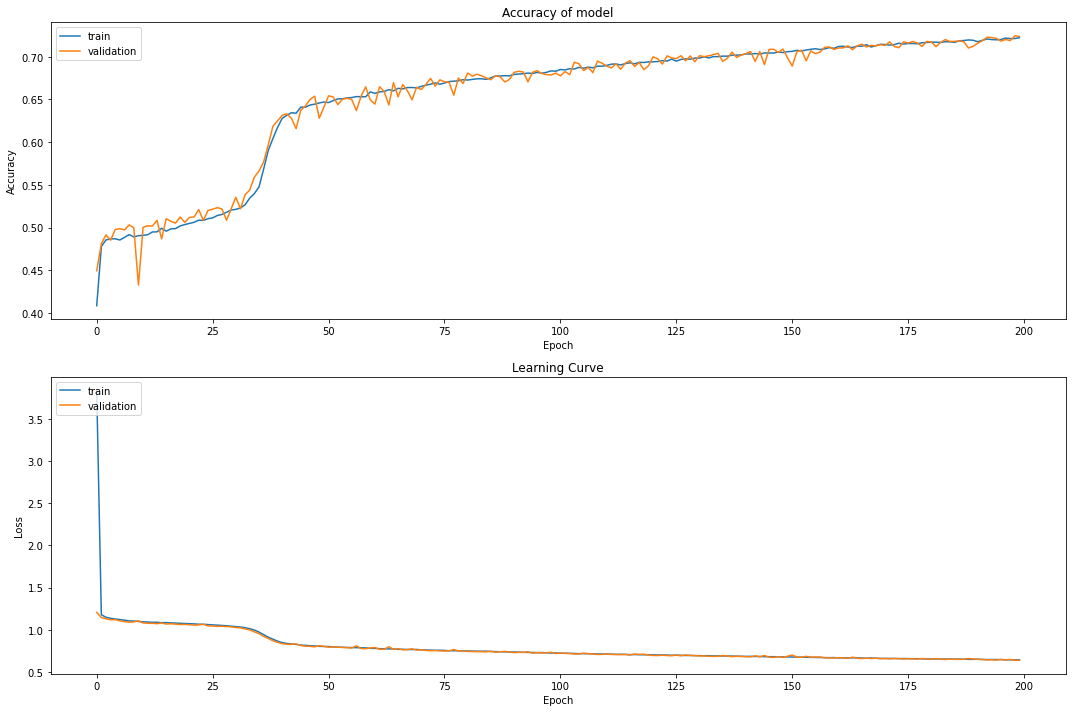

In [36]:
# visualize accuracy
accuracy_viz(history)

In [40]:
y_pred = gen_report(history.model, features_test, labels_test)

Test loss: 0.6414595246315002
Test accuracy: 0.7259536981582642
                   precision    recall  f1-score   support

       Spruce/Fir       0.71      0.71      0.71     42368
   Lodgepole Pine       0.75      0.81      0.78     56661
   Ponderosa Pine       0.63      0.83      0.72      7151
Cottonwood/Willow       0.71      0.32      0.44       549
            Aspen       0.72      0.11      0.19      1899
      Douglas-fir       0.47      0.07      0.12      3473
        Krummholz       0.79      0.34      0.47      4102

         accuracy                           0.73    116203
        macro avg       0.68      0.46      0.49    116203
     weighted avg       0.72      0.73      0.71    116203



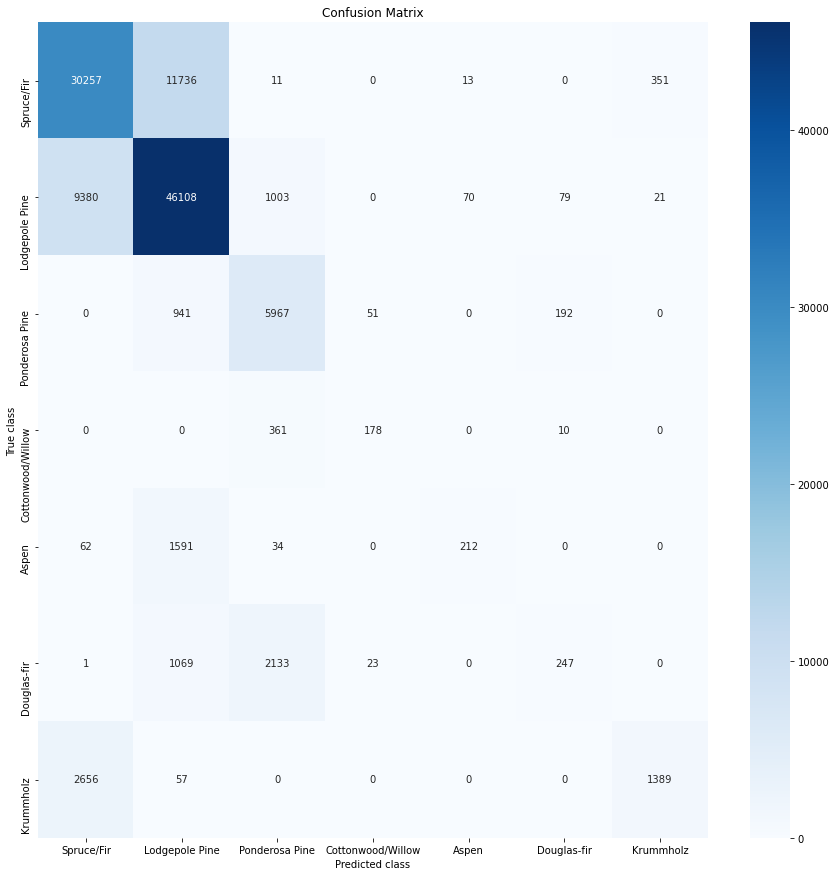

In [41]:
# generate heatmap
heatmap_viz(class_names, y_pred, labels_test)